<a href="https://colab.research.google.com/github/up2113232/up2113232_coursework/blob/dev/Q3_folder/Q3_Activation_Functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How do activation functions affect a neural networks performance?

This notebook builds upon the previous Q2 notebook to explore how one of our neural network parameters affects its performance. From previous testing we see that our neural network didn't perform well when trying to predict psychological scores in the dataset.

We will continue this testing by using various activation functions to see how it affects the networks performance.

**Dataset:** Online Gaming Anxiety Data from Kaggle
**Target Variables:** GAD_T, SWL_T, SPIN_T

# What are activation functions?

An activation function takes the data from our dataset and creates a line which has a specific gradient for the corresponding value for each data point. This gradient tells our network how to learn:

- Steep gradients, tells our neural network to learn better from this data
- Shallow gradients, tells our neural network to learn less effectively from this data.

# Visualising the functions

Its much easier to see how each function treats the data than truing to imagine it, so lets create some plots to see the lines

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from functions import plot_activation_functions

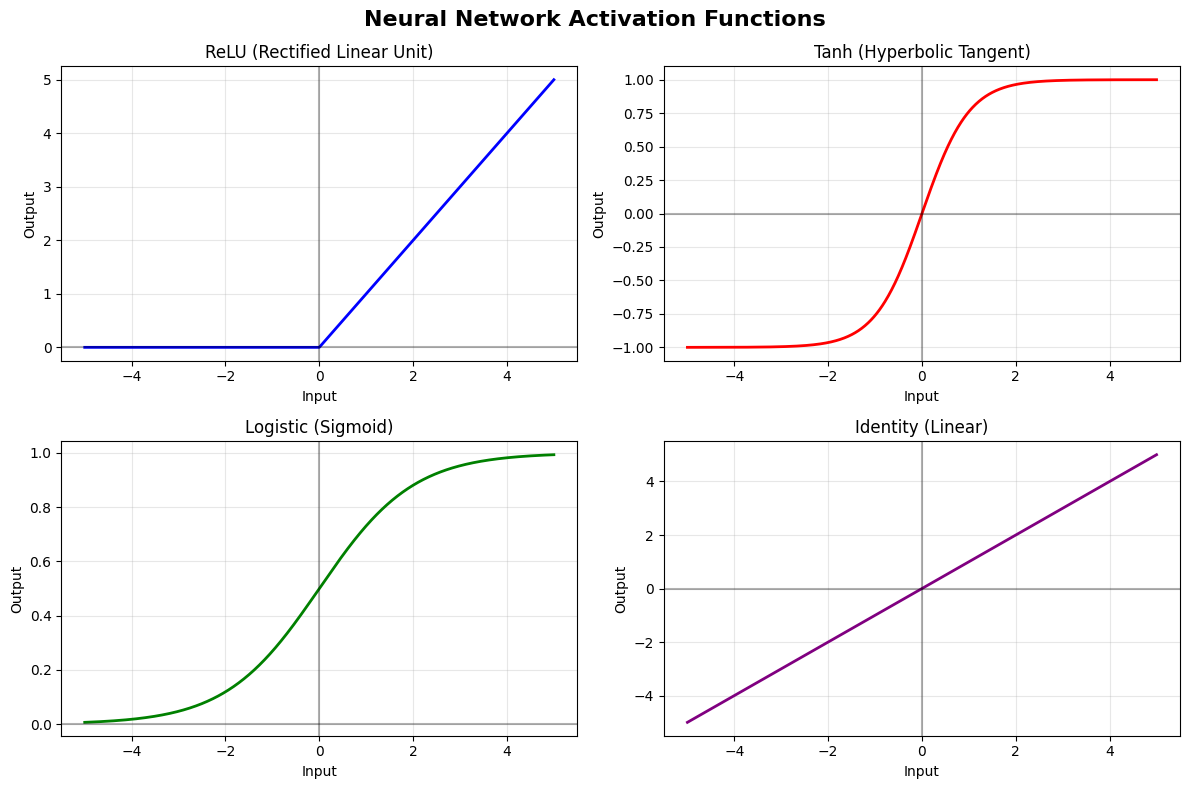

In [4]:
plot_activation_functions()

# What we can tell from the plots

Relu:
- Doesn't learn at all from negative values, Gradient = 0
- Learns well from positve values, Gradient = 1

Tanh:
- Learns well from smaller values, steeper gradient near 0
- Learns less effectively with extreme values, shallower gradient away from 0

Logistic/Sigmoid:
- Works the same as tanh but all gradients are dampened
- Maximum gradient = 0.5 at x = 0

Linear:
- Gives all inputs a gradient of 1


# Testing

How will we approach our question?

We will use our initial code from Q2 to clean our data and setup our neural network. We will then use each activation function and measure its R2 value and the time taken to train our neural network.

Note* - due to our previous results we will do this experiment twice, one with early stopping and one without as we have seen that our network struggles to learn from this complex data as psychology is hard to predict. We will see if all activations stop after a similar amount of iterations and how this affects accuracy, and then see how the lack of early stopping affects the training time. This second experiment will have a fewer number of iterations to help speed up our experiment due to Colab's slower processing speed.

Let's begin by importing the rest of our libraries


In [1]:
# Import necessary libraries
import sys # Used for system-specific parameters and functions, such as modifying the Python path.
import os  # Provides a way of using operating system dependent functionality, such as file paths.

# Add parent directory to path to import our functions
# This line ensures Python can find our custom 'functions.py' file, which contains
# helper functions for data cleaning, encoding, splitting, and scaling.
sys.path.append('..')

# Core data manipulation and visualisation libraries
# pandas is crucial for handling data in tables (DataFrames).
import pandas as pd
# numpy is used for numerical operations, especially with arrays.
import numpy as np
# matplotlib is a foundational library for creating visualisations.
import matplotlib.pyplot as plt
# seaborn is built on matplotlib and provides a higher-level graphics.
import seaborn as sns

# Machine learning and preprocessing libraries from scikit-learn
# train_test_split: for dividing data into training and testing sets.
# cross_val_score: for evaluating model performance using cross-validation.
# GridSearchCV: for hyperparameter tuning (finding the best parameters for a model).
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# StandardScaler: for standardising features by removing the mean and scaling to unit variance.
# LabelEncoder: for converting categorical labels into numerical format.
# MinMaxScaler: for scaling features to a given range, usually between zero and one.
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
# mean_squared_error, mean_absolute_error, r2_score: metrics to evaluate regression model performance.
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# MLPRegressor: Multi-layer Perceptron regressor, a type of neural network for regression tasks.
from sklearn.neural_network import MLPRegressor
# MultiOutputRegressor: a strategy for fitting a single regressor on multiple targets.
from sklearn.multioutput import MultiOutputRegressor

# System and warnings
# This line is used to ignore warning messages that might clutter the output.
import warnings
warnings.filterwarnings('ignore')

Importing our functions

In [2]:
# From our 'functions.py' file, we import specific helper functions.
# These functions encapsulate common data processing steps, making our main notebook cleaner and more organised.
# - clean_data: handles initial data cleaning (e.g., duplicates, basic missing value handling).
# - encode_features: converts non-numerical (categorical) data into numerical format that machine learning models can understand.
# - split_data: divides the dataset into training and testing sets.
# - scale_features: normalises or standardises numerical features.
from functions import clean_data, encode_features, split_data, scale_features
from functions import plot_r2_values, plot_mae_values

Reading and storing the data

In [3]:
# Load the dataset from a CSV file into a pandas DataFrame.
# The 'encoding' parameter is specified to handle potential character encoding issues in the file.
# We use a try-except block to gracefully handle the case where the file might not be found.
try:
  df = pd.read_csv('gaming_anxiety_data.csv', encoding='ISO-8859-1')

except FileNotFoundError:
  print(" File not found! Please upload your dataset first.")

Select our feature and target columns

In [4]:
# Define the columns that will be used as input features for our Neural Network.
# These are the independent variables (X) that the network will use to make predictions.
feature_columns = ['GADE', 'Game', 'Hours', 'earnings', 'whyplay',
                   'streams', 'Narcissism', 'Gender',
                   'Age', 'Work', 'Playstyle']

# Define the target columns. These are the dependent variables (y) we want to predict.
# Our network will try to learn the relationship between 'feature_columns' and 'target_columns'.
target_columns = ['GAD_T', 'SWL_T', 'SPIN_T']

# Create a new DataFrame 'df' containing only the selected feature and target columns.
df = df[feature_columns + target_columns].copy()

Initial data cleaning

In [5]:
# Calls the 'clean_data' function (imported from functions.py) to handle initial data cleaning steps.
# This function removes duplicate rows and displays information about missing values.
# The cleaned data is stored in a new DataFrame called 'df_cleaned_initial'.
print("Cleaning dataset...")
df_cleaned_initial = clean_data(df)

Cleaning dataset...
Missing values per column:
GADE          649
Game            0
Hours          30
earnings        0
whyplay         0
streams       100
Narcissism     23
Gender          0
Age             0
Work           38
Playstyle       0
GAD_T           0
SWL_T           0
SPIN_T        650
dtype: int64
Removed 0 rows with missing values
Removed 51 duplicate rows


Encoding our values and second clean

In [6]:
# We will encode the string values (categorical features) into corresponding numbers using 'encode_features'.
# This is necessary because Neural Networks typically require numerical inputs.
df_encoded = encode_features(df_cleaned_initial)

# We will then clean up any remaining missing values by dropping rows that contain NaN (Not a Number).
# This ensures that our final dataset 'df_clean' is entirely numerical and free of missing data.
df_clean = df_encoded.dropna()

# Print a summary of missing values to confirm the cleaning process was successful.
print(f"\n Original Missing values: {df.isnull().sum().sum()}")
print(f" Missing values after cleaning and encoding: {df_clean.isnull().sum().sum()}")
# If there are still missing values, this block will print which columns contain them.
if df_clean.isnull().sum().sum() > 0:
    print("Columns with missing values in df_clean:")
    print(df_clean.isnull().sum()[df_clean.isnull().sum() > 0])


 Original Missing values: 1490
 Missing values after cleaning and encoding: 0


Now we will encode our data using Standard scaling, this may cause some bias that we will explore later.

In [7]:
# Separate the features (X) from the target variables (y).
# X contains the input data, and y contains the values we want to predict.
X = df_clean[feature_columns]
y = df_clean[target_columns]

# Define the proportion of data to be used for testing (20%) and a random state for reproducibility.
test_size = 0.2
random_state = 42

# Split the data into training and testing sets using the split_data function.
# X_train, y_train are used to train the model.
# X_test, y_test are used to evaluate the model's performance on unseen data.
X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size, random_state=random_state)

# Initialise StandardScaler to normalise the feature data.
# Scaling is important for neural networks as it helps with faster convergence and better performance.
scaler = StandardScaler()
# Fit the scaler on the training features and then transform both training and test features.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialise another StandardScaler for the target variables.
# It's good practice to scale target variables as well when using regression models.
target_scaler = StandardScaler()
# Fit and transform the training target variables.
y_train_scaled = target_scaler.fit_transform(y_train)
# Transform the test target variables (using the scaler fitted on training targets).
y_test_scaled = target_scaler.transform(y_test)

Now is the time we will set up our neural netwrok structure, we will create and train each neural network inside a for loop to train all models in one piece of code for convenience.